This is an auto-generated notebook.

Advanced Lane Line Finding using Images
In this notebook, we are going to build a computer vision model for identifying lane lines in road images.
Camera calibration
Extracting lane line pixels using color thresholding
Perspective transformation
Calculating lane curvature
Producing output images and videos with highlighted lane lines

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
import numpy as np
import cv2
import glob
import os
from ipywidgets import interact, interactive, fixed
import imageio
imageio.plugins.ffmpeg.download()
from moviepy.editor import VideoFileClip
import adv_lane_lines 


%matplotlib inline

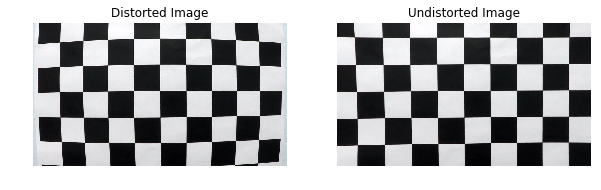

In [2]:
#%load_ext autoreload
#%autoreload 2

# Camera calibration 
camera_cal_images = glob.glob('../camera_cal/calibration*.jpg')
calibrate = adv_lane_lines.CameraCalibrate(camera_cal_images, 9, 6)
                                        

# Take example distorted image and undistort it using saved camera coefficients
distorted_image = '../camera_cal/calibration1.jpg'
distorted_image = cv2.imread(distorted_image)
undistorted_image = calibrate.undistort(distorted_image)

# Display both distorted and undistorted images
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Distorted Image')
plt.imshow(distorted_image)


plt.subplot(1, 2, 2)
plt.imshow(undistorted_image)
plt.axis('off')
plt.title('Undistorted Image')

plt.show()



In [3]:
#%load_ext autoreload
#%autoreload 2

# Distortion correction looks OK,save undistorted images to ./output_images/cameral_cal folder
# 

UNDISTORTED_OUT_IMAGES_LOC = '../output_images/camera_cal/'

#calibrate.saveUndistorted
#camera_cal_images = glob.glob('../camera_cal/calibration*.jpg')

for image in camera_cal_images:
    start = image.rindex('/') + 1
    end = image.rindex('.')
    dest_path = UNDISTORTED_OUT_IMAGES_LOC + image[start:end] + '.jpg'
    
    image = cv2.imread(image)
    undistorted_image = calibrate.undistort(image)
    # Save undistorted image
    cv2.imwrite(dest_path, undistorted_image)


In [4]:
def load_test_images(glob_regex='../test_images/*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images



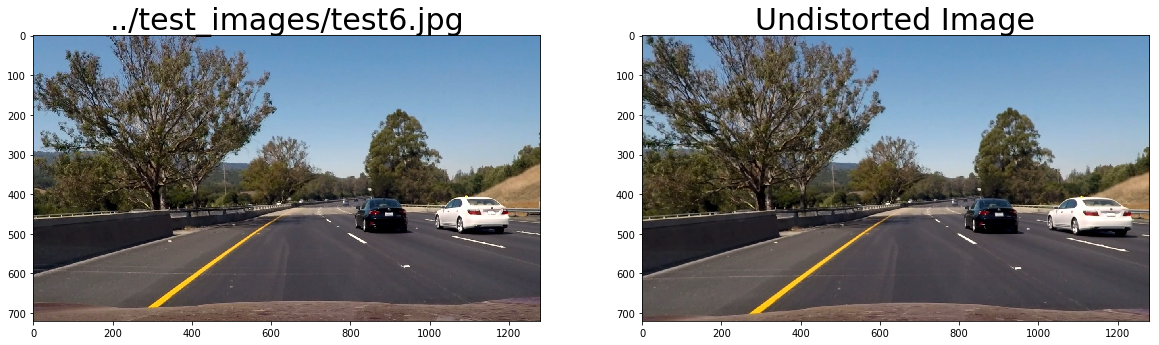

In [5]:

images = load_test_images()
#images = load_test_video(file_name='project_video_shadow.mp4')
# images = load_test_video(file_name='project_video_short.mp4')
@interact
def undistort_test_images(images=fixed(images), i:(0,len(images)-1)=0):
    file,image=images[i]
    undistorted=calibrate.undistort(image)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(image)
    ax1.set_title(file, fontsize=30)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=30)

In [6]:
#%load_ext autoreload
#%autoreload 2

# Next we are going to save distrotion corrected images to 
# ./output_images/test_images_ undistorted folder

UNDIST_IMAGES_LOCATION = '../output_images/undistorted_test_images/'
TEST_IMAGES_LOCATION = '../test_images/'
images_loc = os.listdir(TEST_IMAGES_LOCATION)

for image_loc in images_loc:
    corred_image_file = UNDIST_IMAGES_LOCATION + image_loc
    distorted_image_location = TEST_IMAGES_LOCATION + image_loc
    distorted_image_location = cv2.imread(distorted_image_location)
    corrected_image = calibrate.undistort(distorted_image_location)
    cv2.imwrite(corred_image_file, corrected_image)

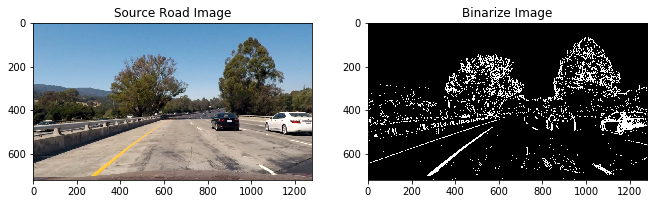

In [7]:

# Now we are ready to do color thresholding and masking 
# in order to find out binary images with lane lines.
output_undistorted_img = mpimg.imread('../output_images/undistorted_test_images/test1.jpg')
binary_img = adv_lane_lines.binarize(output_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (170, 255), 
                                                 l_thresh = (50, 255))
plt.figure(figsize=(11, 6))
#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.axis('on')
plt.title('Source Road Image')
plt.imshow(output_undistorted_img)

plt.subplot(1, 2, 2)
plt.axis('on')
plt.title('Binarize Image')
plt.imshow(binary_img)

plt.show()

In [8]:

# Next we are going to save all binary threshold image to
# ./output_images/test_images_binary folder

OUTPUT_DIR = '../output_images/test_images_binarized/'
INPUT_DIR = '../output_images/undistorted_test_images/'

for file in os.listdir(INPUT_DIR):
    saved_undistorted_img = mpimg.imread(INPUT_DIR + file)
    binary_img = adv_lane_lines.binarize(saved_undistorted_img,
                                                 gray_thresh = (20, 255), 
                                                 s_thresh = (150, 255), 
                                                 l_thresh = (120, 255))
    cv2.imwrite(OUTPUT_DIR + file, binary_img)
print('{} images saved to {} directory'.format(len(os.listdir(INPUT_DIR)),
                                              OUTPUT_DIR))

8 images saved to ../output_images/test_images_binarized/ directory


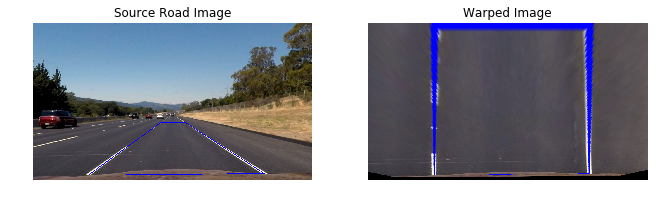

In [9]:
image = mpimg.imread('../output_images/undistorted_test_images/straight_lines2.jpg')

corners = np.float32([[253, 697],[585,456],[700, 456],[1061,690]])
new_top_left = np.array([corners[0, 0], 0])
new_top_right = np.array([corners[3, 0], 0])
offset = [50, 0]

img_size = (image.shape[1], image.shape[0])
src = np.float32([corners[0], corners[1], corners[2], corners[3]])
dst = np.float32([corners[0] + offset, new_top_left + offset, new_top_right - offset, corners[3] - offset])

perspective = adv_lane_lines.Transformation(src, dst)


cv2.line(image, (253, 697), (585,456), color=[0,0,255], thickness=2)
cv2.line(image, (585,456), (700, 456), color=[0,0,255], thickness=2)
cv2.line(image, (700, 456), (1061,690), color=[0,0,255], thickness=2)
cv2.line(image, (1061,690), (253, 697), color=[0,0,255], thickness=2)

warped_img = perspective.transform(image)

plt.figure(figsize=(11, 5))
plt.subplot(1, 2, 1)
plt.axis('off')
plt.title('Source Road Image')
plt.imshow(image)


plt.subplot(1, 2, 2)
plt.axis('off')
plt.title('Warped Image')
plt.imshow(warped_img)

plt.show()

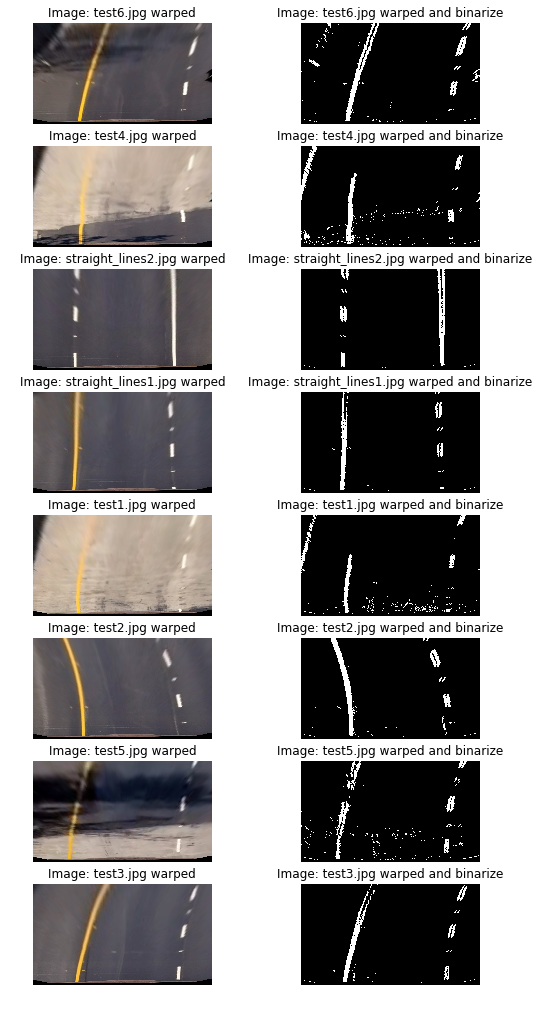

In [10]:
index = 0
plt.figure(figsize=(8, 18))
gs = gridspec.GridSpec(8, 2)
gs.update(wspace=0.5, hspace=0.05)

binary_images = []
for file in os.listdir('../output_images/undistorted_test_images/'):
    image = mpimg.imread('../output_images/undistorted_test_images/' + file)
        
    ax1 = plt.subplot(gs[index])
    undistorted = perspective.transform(image)
    ax1.axis('off')
    ax1.set_title('Image: {} warped'.format(file))
    ax1.imshow(undistorted)
    
    index += 1
    
    binary_img = adv_lane_lines.binarize(undistorted)
    binary_images.append(binary_img)
    ax2 = plt.subplot(gs[index])
    ax2.axis('off')
    ax2.set_title('Image: {} warped and binarize'.format(file))
    ax2.imshow(binary_img)
    
    index += 1
    
plt.show()

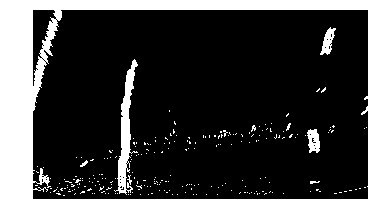

In [11]:
warped_image = binary_images[1] 
plt.imshow(warped_image)
plt.axis('off')
plt.show()

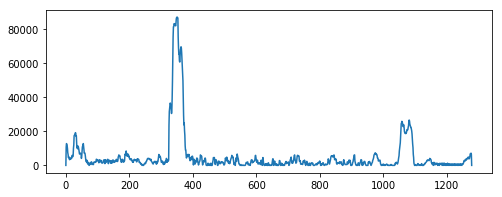

In [12]:
histogram = np.sum(warped_image[warped_image.shape[0] // 2:, :, 0], axis=0)
plt.figure(figsize=(8, 3))
plt.plot(histogram)
plt.show()